# Cart Pole Control

<!--
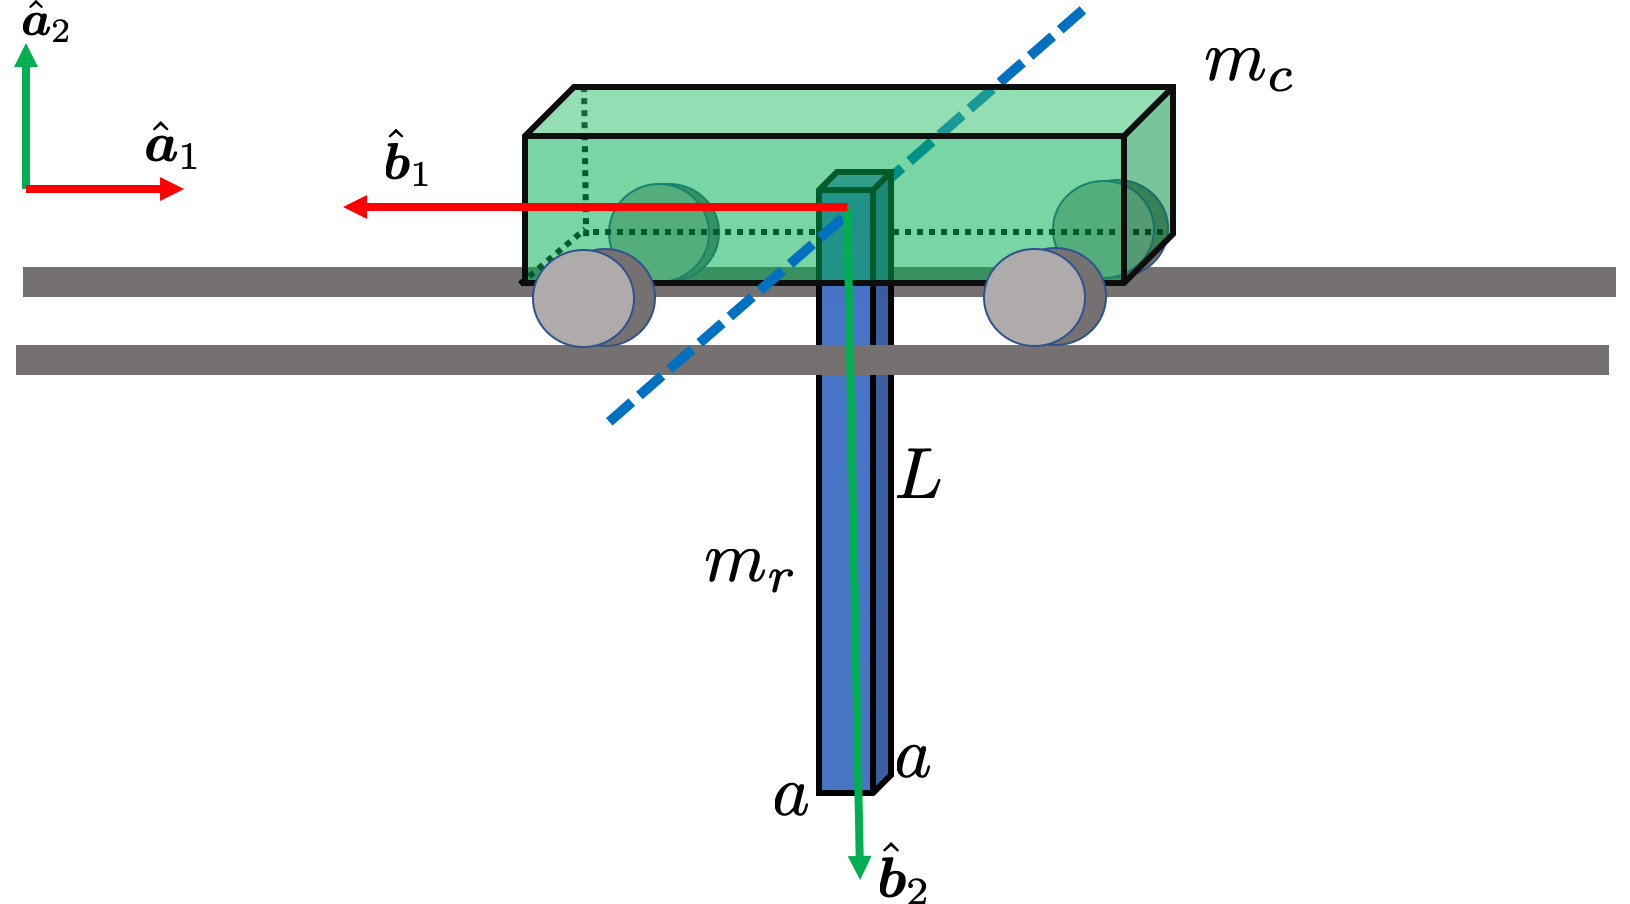
-->


<div>
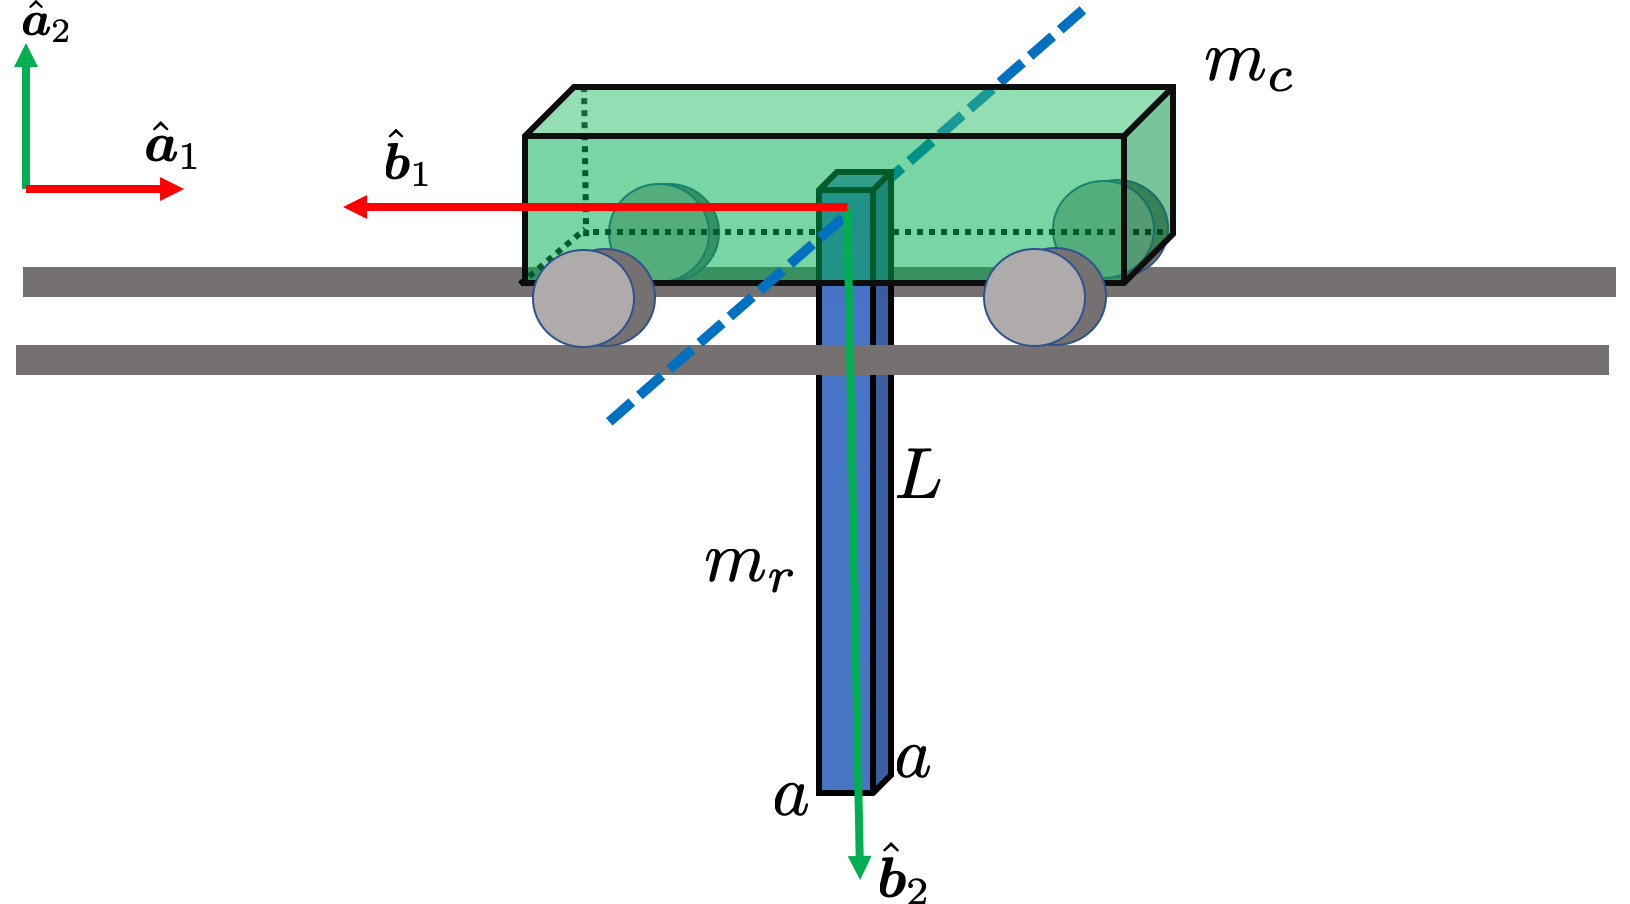
</div>


## System Description

For the cart-pole problem shown in the figure, the system consists of a cart on a one-dimensional track with mass $m_c$ and a rectangular pendulum attached at one end, the mass is $m_r$, and dimensions $a\times a \times L$. The control input is ${u}= \ddot{x} \hat{a}_{1}$. Compose the dynamics for the cart-pole system. Let $\theta$ be the angle between the aligned $A$ and $B$ frames. In the current figure with the pendulum hanging down $\theta = \pi$. 

### Control Objective:
Find the ${u}(t)$ such that 
$$\lim_{t\rightarrow \infty} \theta(t)=0$$
Achieve this with initial conditions being 
1.  $\theta(t_0)=0.1$ radians
2. $\theta(t_0) = \frac{\pi}{2}$ (for extra credit)






# Derive EoM for Cartpole using Lagrangian
### The equation is the same as what I derived by hand and also the EoM from reference. 

## Kinematics

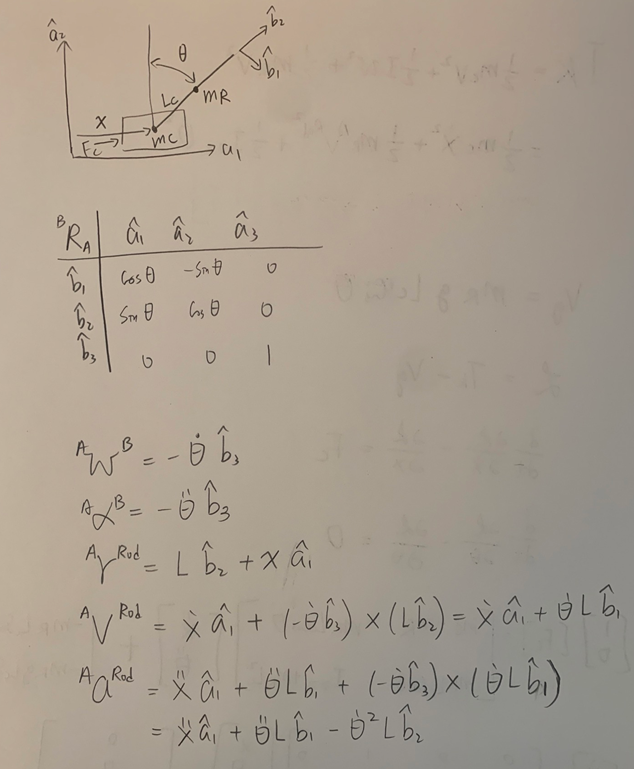

## Lagrangian

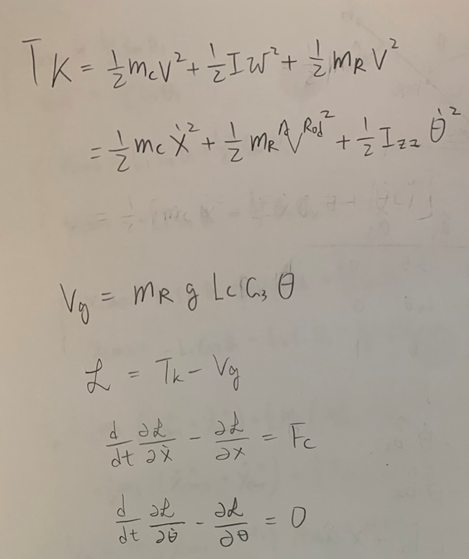

In [29]:
g = sp.symbols('g')

mC = sp.symbols('m_C')

mR = sp.symbols('m_R')
Izz = sp.symbols('I_zz')

LC = sp.symbols('LC')

t = sp.symbols('t')
XC = sp.Function('x')(t)
dXC = sp.diff(XC,t)
ddXC = sp.diff(dXC,t)

thR = sp.Function('th')(t)
dthR = sp.diff(thR,t)
ddthR = sp.diff(dthR,t)

Fc = sp.symbols(r'F_c')

Tk = (1/2)*mC*dXC**2 + (1/2)*mR*((dXC+sp.cos(thR)*dthR*LC)**2 + (-sp.sin(thR)*dthR*LC)**2) + (1/2)*Izz*dthR**2
Vg = mR*g*LC*sp.cos(thR)

La = Tk -Vg

eq1 = sp.diff(sp.diff(La,dXC),t) - sp.diff(La,XC) - Fc
eq2 = sp.diff(sp.diff(La,dthR),t) - sp.diff(La,thR)

In [30]:
sp.simplify(eq1)

-F_c + 1.0*m_C*Derivative(x(t), (t, 2)) + m_R*(-LC*sin(th(t))*Derivative(th(t), t)**2 + LC*cos(th(t))*Derivative(th(t), (t, 2)) + Derivative(x(t), (t, 2)))

In [31]:
sp.simplify(eq2)

1.0*I_zz*Derivative(th(t), (t, 2)) + 1.0*LC**2*m_R*Derivative(th(t), (t, 2)) - 1.0*LC*g*m_R*sin(th(t)) + 1.0*LC*m_R*cos(th(t))*Derivative(x(t), (t, 2))

# Derive Matrix Form of EoM and Linearized EoM

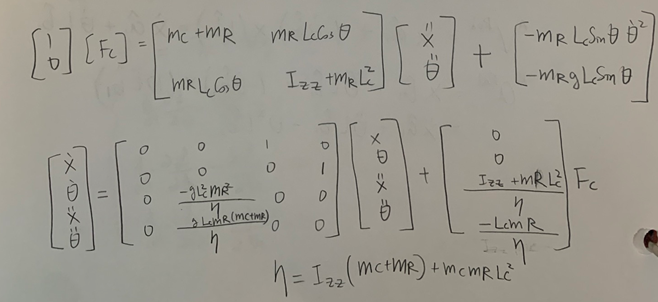

#### The above equations are useful for control design. I have used pole placement and LQR for designing the controller's gains. 

# Control Law

### The above state-space form can be express in terms of matrices A and B

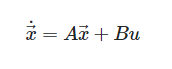

### Control input u is Fc applied force

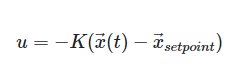

### The eigenvalues of matrix A has non-negative real part means the system is unstable

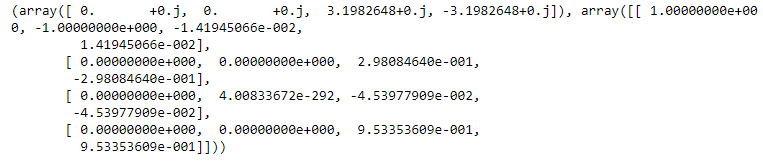

### Applying pole placement in order to make the following matrix to have negative real part eigenvalues, which can justify the system would be stabilized with control input u

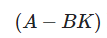

### I have tested different poles, the following set works pretty well for the first IC

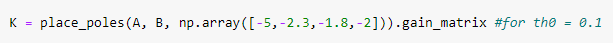

### Unfortunately, pole placement didn't work well if we have large errors in the beginning for x and th
### If we have large initial theta, such as 0.8 or 0.9, or the cart has to move to desired X position, we will need to find another control gains for each case.

## Applying LQR to find the optimized K for the problem works better.

### I utilized scipy to help me do LQR calculation (see estimate function)

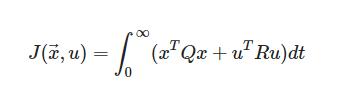

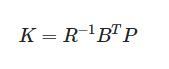

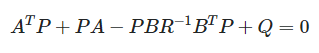

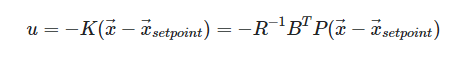

# Simulation

In [37]:
%matplotlib notebook
# %matplotlib inline

In [39]:
#!/usr/bin/env python
import numpy as np #import numpy as np means: import libary numpy and let me refer to it now on as 'np'
from scipy import integrate #this will allow us to perform integration (like matlab ode45)
#The following will allow us to plot and animate
import matplotlib.pyplot as plt  #This is used for static graphs
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3
# import matplotlib.animation as animation 
from matplotlib import animation, rc #this will be used to play animations
#rc('text', usetex=True) #if you want to use latex in plot legends
import sympy as sp
from scipy.signal import place_poles
import scipy
import math
import time
#import cvxpy

#Set Parameters
def inertia_matrix_cm(L,W,H,m):
    '''
    Inertia matrix L on y axis, W on x axis and H on z axis
    m: mass (kg)
    Output: inertia matrix about the cm aligned with principle axis
    '''
    I = (m/12.0)*np.matrix([[L**2 + H**2,0,0],[0,W**2+H**2,0],[0,0,L**2+W**2]])
    return I
g = 9.81
aC = 0.1
LC = 0.5
mC = 10.0 #units kg
IC = inertia_matrix_cm(aC,LC,aC,mC)

aR = 0.1
LR = 0.75
mR = 0.5 #units kg
IR = inertia_matrix_cm(LR,aR,aR,mR)
Izz = IR[1,1]
params_cp = {'cart':{'L':LC, 'I':IC,'m':mC,'a':aC},'pole':{'L':LR, 'I':IR,'m':mR,'a':aR}}

## Cartpole Dynamics EoM, derived from Lagrangian

In [40]:
def cart_pole_func(): # cart_pole dynamics EoM, nonlinear equation
    th = sp.symbols(r'th')
    dth = sp.symbols(r'dth')
    Fc = sp.symbols(r'Fc')
    
    M = sp.Matrix([[mC+mR, mR*(1/2)*LR*sp.cos(th)],[mR*(1/2)*LR*sp.cos(th), Izz+mR*((1/2)*LR)**2]])
    Q = sp.Matrix([[-mR*(1/2)*LR*sp.sin(th)*dth**2],[-mR*g*(1/2)*LR*sp.sin(th)]])

    
    eq = M.inv() @ (sp.Matrix([[1],[0]])@ sp.Matrix([Fc]) - Q)
    
    
    ddx_func = sp.lambdify((th,dth,Fc), eq[0])
    ddth_func = sp.lambdify((th,dth,Fc), eq[1])
    
    return (ddx_func, ddth_func)

In [32]:
def cart_pole_dyeq():
    L = LR*0.5
    
    t = sp.symbols('t')
    XC = sp.Function('x')(t)
    dXC = sp.diff(XC,t)
    ddXC = sp.diff(dXC,t)

    thR = sp.Function('th')(t)
    dthR = sp.diff(thR,t)
    ddthR = sp.diff(dthR,t)

    Fc = sp.symbols(r'F_c')
    
    X_R = XC + L*sp.sin(thR)
    Y_R = L*sp.cos(thR)
    
    V_R_sq = sp.diff(X_R,t)**2 + sp.diff(Y_R,t)**2

    Tk = (1/2)*mC*dXC**2 + (1/2)*mR*V_R_sq + (1/2)*Izz*dthR**2
    Vg = mR*g*Y_R

    La = Tk -Vg

    eq1 = sp.diff(sp.diff(La,dXC),t) - sp.diff(La,XC) - Fc
    eq2 = sp.diff(sp.diff(La,dthR),t) - sp.diff(La,thR)
    
    sols = sp.solve([eq1,eq2], (ddXC, ddthR), simplify=False)
    
    print(sols[ddXC])
    print(sols[ddthR])
    
    ddX_func = sp.lambdify((thR, dthR, Fc), sols[ddXC]) 
    ddth_func = sp.lambdify((thR, dthR, Fc), sols[ddthR]) 
    
    
    return (ddX_func,ddth_func)

In [33]:
ddx_func, ddth_func = cart_pole_dyeq()

512.0*F_c*I_zz/(512.0*I_zz*m_C + 512.0*I_zz*m_R + 72.0*m_C*m_R*sin(th(t))**2 + 72.0*m_C*m_R*cos(th(t))**2 + 72.0*m_R**2*sin(th(t))**2) + 72.0*F_c*m_R*sin(th(t))**2/(512.0*I_zz*m_C + 512.0*I_zz*m_R + 72.0*m_C*m_R*sin(th(t))**2 + 72.0*m_C*m_R*cos(th(t))**2 + 72.0*m_R**2*sin(th(t))**2) + 72.0*F_c*m_R*cos(th(t))**2/(512.0*I_zz*m_C + 512.0*I_zz*m_R + 72.0*m_C*m_R*sin(th(t))**2 + 72.0*m_C*m_R*cos(th(t))**2 + 72.0*m_R**2*sin(th(t))**2) + 192.0*I_zz*m_R*sin(th(t))*Derivative(th(t), t)**2/(512.0*I_zz*m_C + 512.0*I_zz*m_R + 72.0*m_C*m_R*sin(th(t))**2 + 72.0*m_C*m_R*cos(th(t))**2 + 72.0*m_R**2*sin(th(t))**2) - 72.0*g*m_R**2*sin(th(t))*cos(th(t))/(512.0*I_zz*m_C + 512.0*I_zz*m_R + 72.0*m_C*m_R*sin(th(t))**2 + 72.0*m_C*m_R*cos(th(t))**2 + 72.0*m_R**2*sin(th(t))**2) + 27.0*m_R**2*sin(th(t))**3*Derivative(th(t), t)**2/(512.0*I_zz*m_C + 512.0*I_zz*m_R + 72.0*m_C*m_R*sin(th(t))**2 + 72.0*m_C*m_R*cos(th(t))**2 + 72.0*m_R**2*sin(th(t))**2) + 27.0*m_R**2*sin(th(t))*cos(th(t))**2*Derivative(th(t), t)**2/(5

## Deciding K controller gains

In [47]:
def estimate(): # using pole placement and LQR for choosing K values
    # linearized equation
    A = np.array([[0,0,1,0],[0,0,0,1],[0,-(g*mR**2*LC**2)/(Izz*(mC+mR) + mC*mR*LC**2),0,0],[0,g*LC*mR*(mC+mR)*LC/(Izz*(mC+mR) + mC*mR*LC**2),0,0]])
    B = np.array([[0],[0],[(Izz+mR*LC**2)/(Izz*(mC+mR)+mC*mR*LC**2)],[-LC*mR/(Izz*(mC+mR)+mC*mR*LC**2)]])
    #print(scipy.linalg.eig(A))
    
    #K = place_poles(A, B, np.array([-5,-2.3,-1.8,-2])).gain_matrix #for th0 = 0.1
    
    # LQR Method
    Q = np.array([[1,0,0,0],[0,10,0,0],[0,0,1,0],[0,0,0,1]])
    R = np.array([[0.001]])
    
    P = np.matrix(scipy.linalg.solve_continuous_are(A, B, Q, R))
    K = np.matrix(scipy.linalg.inv(R)*(B.T*P))
    
    return K

In [45]:
K = estimate()

In [43]:
K # LQR

matrix([[ -31.6227766 , -304.32879949,  -66.56041938,  -97.98194519]])

In [46]:
K # POLE PLACEMENT

array([[ -44.71758458, -289.7097509 ,  -75.58783982,  -93.93437938]])

## Dynamics Calculation

In [58]:
ddx_func, ddth_func = cart_pole_func()

def cart_pole_dyn(s,t,params):
    '''
    Input:
    - s: states of the system in numpy matrix (4x1 vector) [x, th, dx, dth]
    - params: dictionary of parameter values
    - des: xdes, dxdes
    ------
    Output:
    - ds/dt: derivative states vector (4x1 vector) [dx, dth, ddx, ddth]
    '''
    mC = params['cart']['m']
    mR = params['pole']['m']
    LR = params['pole']['L']
    IR = params['pole']['I']
   
    x = s[0]
    th = s[1]
    dx = s[2]
    dth = s[3]
    
    
    des_th = 0 # pointing up
    des_dth = 0 
    des_x = 0
    des_dx = 0
    
    

    e_th = th - des_th
    e_dth = dth - des_dth
    
    e_x = x - des_x
    e_dx = dx - des_dx
    
    u = -K.dot(np.array([e_x,e_th,e_dx,e_dth]))
    
    
    ddx = ddx_func(th,dth,u)
    ddth = ddth_func(th,dth,u)
    
    ds= [dx, dth, ddx, ddth]
    

    return ds

In [59]:
#now make the time series
max_time = 30
Sec_sub = 20 #second subdivision (frequency/Hz)
dt = 1/Sec_sub #useful for the animation function
t = np.linspace(0,max_time,int(Sec_sub*max_time))
s2_init_list = [[0,0.1,0,0]]#,[-5,0.1,0,0],[-1,0.9,0,0],[0,np.pi/2,0,0],[0,np.pi,0,0]]

#integrate dynamics output
s2_t_list = []
for s2_0 in s2_init_list:
    s2_t_out = integrate.odeint(cart_pole_dyn,s2_0,t, args=(params_cp,))
    s2_t_list.append(s2_t_out)

## Test Cartpole Dynamics without Fc. ICs = [0,0.1,0,0]

<IPython.core.display.Javascript object>


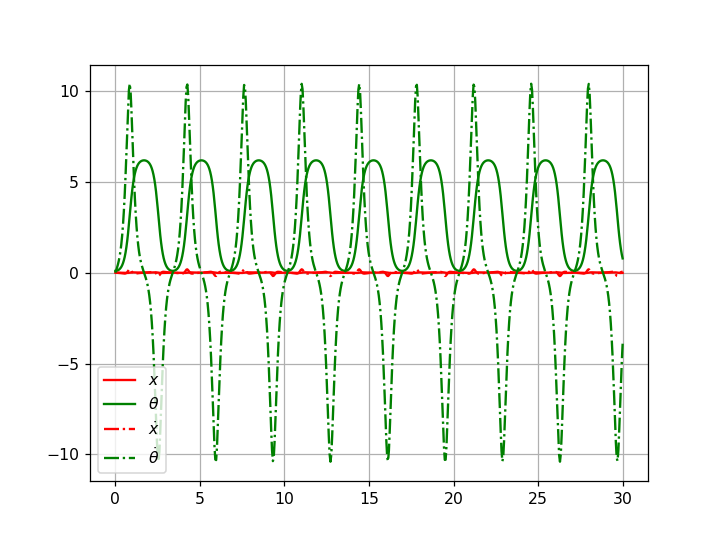

In [60]:
s2_t = s2_t_list[0]

#Now plot the angle vs time
fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t,s2_t[:,0],'r',label='$x$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s2_t[:,1],'g',label='$\\theta$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s2_t[:,2],'-.r',label='$\\dot{x}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s2_t[:,3],'-.g',label='$\\dot{\\theta}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

# LQR and Poleplacement Controls

## 1. IC = [0,0.1,0,0]

<IPython.core.display.Javascript object>


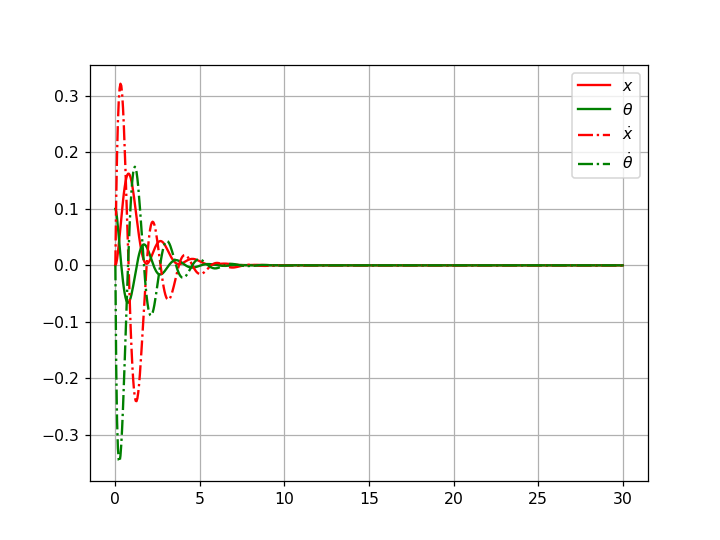

In [54]:
s2_t = s2_t_list[0]

#Now plot the angle vs time
fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t,s2_t[:,0],'r',label='$x$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s2_t[:,1],'g',label='$\\theta$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s2_t[:,2],'-.r',label='$\\dot{x}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s2_t[:,3],'-.g',label='$\\dot{\\theta}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

# Larger initial angle and x position

## Start from x = -5 location

<IPython.core.display.Javascript object>


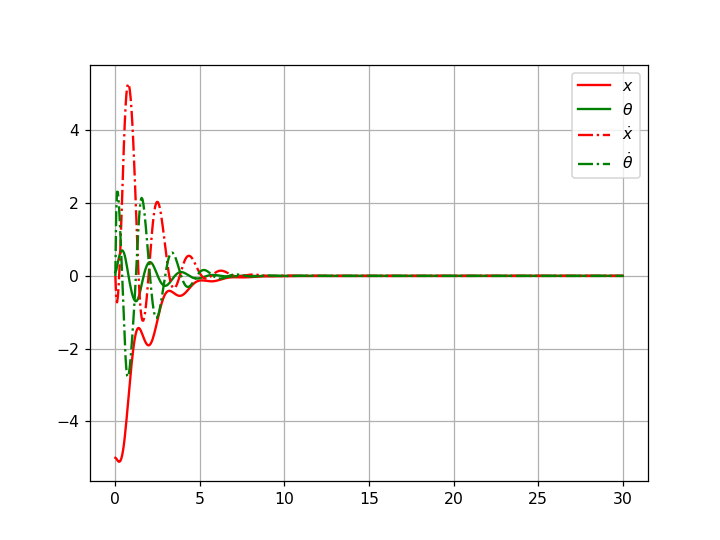

In [53]:
s2_t = s2_t_list[1]

#Now plot the angle vs time
fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t,s2_t[:,0],'r',label='$x$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s2_t[:,1],'g',label='$\\theta$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s2_t[:,2],'-.r',label='$\\dot{x}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s2_t[:,3],'-.g',label='$\\dot{\\theta}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

## Start from th0 = 0.9

<IPython.core.display.Javascript object>


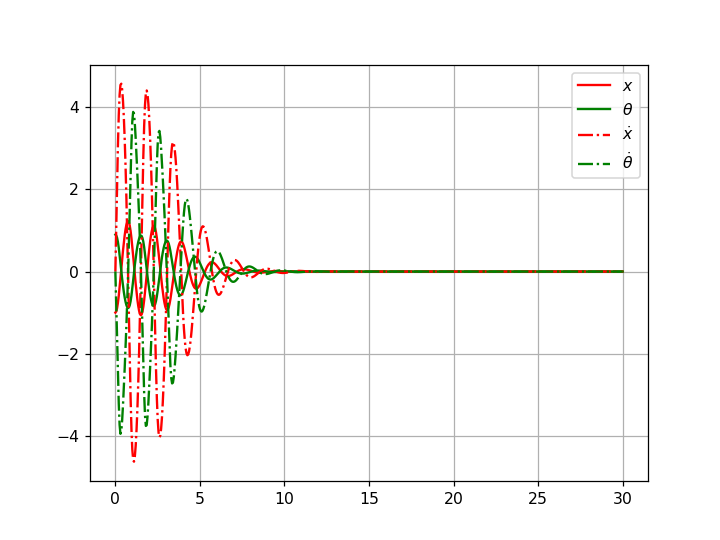

In [55]:
s2_t = s2_t_list[2]

#Now plot the angle vs time
fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=True) #if you want to strictly set the bounds
ax.grid() #this allows us to see the grid
ax.plot(t,s2_t[:,0],'r',label='$x$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s2_t[:,1],'g',label='$\\theta$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s2_t[:,2],'-.r',label='$\\dot{x}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.plot(t,s2_t[:,3],'-.g',label='$\\dot{\\theta}$') #Note: when using latex in legends, use double instead of single '\' for variables
ax.legend() #show the legend

plt.show() #this says display the info here

## Animation

<IPython.core.display.Javascript object>


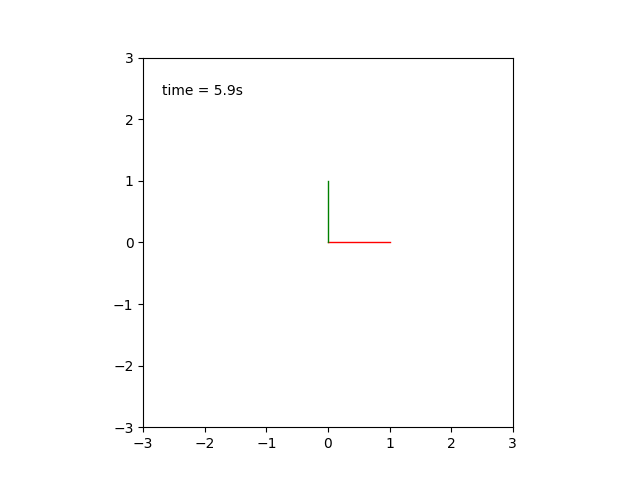

In [243]:
s2_t = s2_t_list[0]
#Simulate Output
from matplotlib import animation, rc #this will be used to play animations
#rc('text', usetex=True) #if you want to use latex in plot legends
from IPython.display import HTML #this is for rendering the animations

#Draw the objects
fig2 = plt.figure();
ax2 = fig2.add_subplot(111, autoscale_on=False, xlim=(-3.0, 3), ylim=(-3.0, 3.0));
ax2.set_aspect('equal')

frame_lengths = 1

#frames
frame_A_x, = ax2.plot([0,frame_lengths], [0,0], '-',color='red', lw=1)
frame_A_y, = ax2.plot([0,0], [0,frame_lengths], '-',color='green', lw=1)

frame_B_x, = ax2.plot([], [], '-',color='red', lw=1)
frame_B_y, = ax2.plot([], [], '-',color='green', lw=1)



#define animation structions
cart, = ax2.plot([], [], '-',color='green', lw=5)
pole, = ax2.plot([], [], '-',color='blue', lw=5)
time_template = 'time = %.1fs';
time_text = ax2.text(0.05, 0.9, '', transform=ax2.transAxes); #sim time object, with location description

def rot_z_axis(th):
    R = np.matrix([[np.cos(th), -np.sin(th),0],
                   [np.sin(th), np.cos(th),0],
                   [0,0,1]])
    #this rotates a frame from F back to A through angle th on the z-axis
    return R

def draw_frames(origin, z_axis_rotation_angle, L):
    #leveraging the fact that all axis undergo rotation about the z axis
    y_local = np.matrix([0,L,0]).T
    x_local = np.matrix([L,0,0]).T
    th = z_axis_rotation_angle
    R = rot_z_axis(th)
    y_rot = R*y_local
    x_rot = R*x_local
    y_rot_vect = [[origin.item(0),origin.item(0)+y_rot.item(0)],
                  [0,y_rot.item(1)]]
    
    x_rot_vect = [[origin.item(0),origin.item(0)+x_rot.item(0)],
                  [0,0+x_rot.item(1)]]
    
    return x_rot_vect,y_rot_vect

def cart_upd(PC, LC, aC):
    link_x = [PC-LC/2,PC-LC/2,PC+LC/2,PC+LC/2,PC-LC/2]
    link_y = [-aC/2,aC/2,aC/2,-aC/2,-aC/2]
    return link_x, link_y

def pole_upd(PC, PR):
    link_x = [PC,PC+PR.item(0)]
    link_y = [0,PR.item(1)]
    return link_x, link_y

def update_system(i,cart,pole,params_cp):
    x,th,dx,dth = s2_t[i,:]
    
    PC = x;
    LC = params_cp['cart']['L'];
    aC = params_cp['cart']['a'];
    R_BA = rot_z_axis(th)
    LR = params_cp['pole']['L']
    PR_local = np.matrix([0,LR,0]).T
    PR = R_BA*PR_local #np.matrix([x-LR/2*np.sin(th), LR/2*np.cos(th)]).T;
   
    #obtain reference frame vectors
    B_x_vec,B_y_vec = draw_frames(PC,th, frame_lengths)
    
    
    #Now update the frames
    frame_A_x.set_data([0,frame_lengths], [0,0])
    frame_A_y.set_data([0,0], [0,frame_lengths])
    frame_B_x.set_data(B_x_vec[0],B_x_vec[1])
    frame_B_y.set_data(B_y_vec[0],B_y_vec[1])
 
    #Now draw the system
    cart.set_data(cart_upd(PC,LC,aC))
    pole.set_data(pole_upd(PC,PR))
    
    time_text.set_text(time_template % (i*dt))
    return [cart, pole],time_text

cp_ani = animation.FuncAnimation(fig2, update_system, np.arange(1, len(t)) , fargs=(cart, pole,params_cp),
                                   interval=50, blit=False)


plt.show()